# Create Equation of State and Fit Well with Varying Pressure

To use `bluebonnet.flow` in a project:

In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d,UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy import interpolate
from lmfit import minimize, Parameters,report_errors,conf_interval,Minimizer,printfuncs
from matplotlib.backends.backend_pdf import PdfPages
from FitFunctions import obfun

from bluebonnet.flow import (
    IdealReservoir, FlowProperties, FlowPropertiesMarder, FlowPropertiesTwoPhase, 
    SinglePhaseReservoir, SinglePhaseReservoirMarder,RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure,BuildPVT
from bluebonnet.forecast.forecastMarder import obfun,FitProductionWithPressure,PlotProductionComparison
from bluebonnet.fluids import HallYarbEOS
from bluebonnet import plotting
pd.set_option('display.max_rows', 100)
import pickle as pkl
Results={}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# If there are previous results saved, load this

In [2]:
Results=pkl.load(file=open("Results.pkl","rb"))

# Create Equation of State

## Read in data about a particular well

In [3]:
WellNumber=12
Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E=E.set_index('Field')
E=E.drop(columns='Unnamed: 0')
E.loc['Initial Pressure Estimate (psi)'][E.columns[0]]
Play=E.loc['Formation/Reservoir'][E.columns[0]]
E

,LORIKEET
Field,
Lease,LORIKEET
Well Number,62
State,LA
Formation/Reservoir,HAYNESVILLE SHALE
Initial Pressure Estimate (psi),9939
Reservoir Temperature (deg F),285.21375
Net Pay (ft),268.39703
Wellbore Diameter (ft),0.7
Porosity,0.0880000591278076


## Create equation of state from well data

In [38]:
FieldValues=E.iloc[:,0]
GasDryness='wet gas'
pvt_gas=BuildPVT(FieldValues,GasDryness)
pvt_gas.to_csv('../tests/data/pvt_gas_'+Play+'_'+str(WellNumber)+'.csv')
pvt_gas

In [6]:
pvt_gas=pd.read_csv('../tests/data/pvt_gas_'+Play+'_'+str(WellNumber)+'.csv')

# Fit one well

Simulation took     1 s; tau is  136.55, Pi is   11023 and M is   38182
Simulation took     1 s; tau is  125.58, Pi is   11023 and M is   38182
Simulation took   1.1 s; tau is  136.55, Pi is   11023 and M is   37603
Simulation took     1 s; tau is  136.55, Pi is   11039 and M is   38182
Simulation took   1.1 s; tau is  129.18, Pi is   11034 and M is   38762
Simulation took   1.1 s; tau is  125.58, Pi is   11039 and M is   39345
Simulation took   1.2 s; tau is  122.04, Pi is   11044 and M is   38956
Simulation took   1.2 s; tau is  115.13, Pi is   11055 and M is   39345
Simulation took   1.2 s; tau is  112.88, Pi is   11032 and M is   39474
Simulation took   1.1 s; tau is  118.55, Pi is   11034 and M is   39151
Simulation took   1.1 s; tau is  118.55, Pi is   11055 and M is   40124
Simulation took   1.1 s; tau is   123.8, Pi is   11031 and M is   38666
Simulation took   1.2 s; tau is  129.18, Pi is   11043 and M is   38827
Simulation took   1.1 s; tau is  126.47, Pi is   11040 and M is 

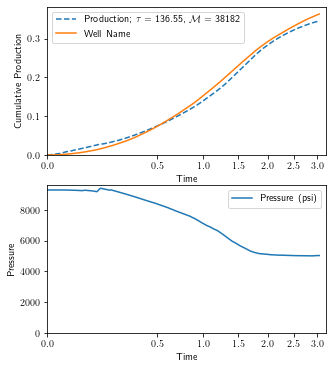

In [14]:
for(WellNumber in range(20,21)): 
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    # This file contains pressure and production data. Rows 1 and 2 have information about units, so skip
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    E=pd.read_csv(open(Filename2,"r"))
    # This file contains an estimate of initial pressure. That's all I need it for here.
    E=E.set_index('Field')
    E=E.drop(columns='Unnamed: 0')
    Pi=float(E.loc['Initial Pressure Estimate (psi)'][E.columns[0]])
    NTimes=100

    if WellNumber in Results.keys():
        result=FitProductionWithPressure(D,pvt_gas,NTimes,Pi,params=Results[WellNumber].params)
    else:
        result=FitProductionWithPressure(D,pvt_gas,NTimes,Pi)
    Results[WellNumber]=result
    result

tau= 131.47, Pi=  11045 and M=   39405


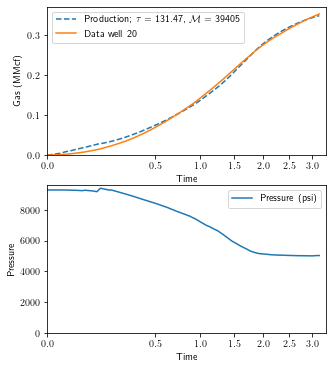

In [27]:
 PlotProductionComparison(D,pvt_gas,result.params,
                          PlotFileName="ProductionComparisonWell"+str(WellNumber)+".pdf",
                         WellName="Data well "+str(WellNumber),
                         ProductionLabel="Gas (MMcf)")

In [16]:
pkl.dump(Results,file=open("Results.pkl","wb"))